In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    learning_curve,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

import numpy as np

In [2]:
df = pd.read_csv("tp_fil_rouge_data.csv", encoding="ISO-8859-1")

print(df.head())
print(f"\nShape       : {df.shape}")
print(f"\nValeurs manquantes :\n{df.isnull().sum()}")
print(f"\nDoublons    : {df.duplicated().sum()}")

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

Shape       : (541909, 8)

Valeurs manquantes :
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country   

## création de la target

In [3]:
df.dropna(subset=["CustomerID"], inplace=True)

df.drop_duplicates(inplace=True)

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# La date de référence = la date la plus récente du dataset
snapshot_date = df["InvoiceDate"].max()

last_purchase = (
    df.groupby("CustomerID")["InvoiceDate"]
    .max()
    .reset_index()
    .rename(columns={"InvoiceDate": "LastPurchase"})
)

last_purchase["churn"] = (
    (snapshot_date - last_purchase["LastPurchase"]).dt.days > 90
).astype(int)

print(last_purchase["churn"].value_counts())

churn
0    2922
1    1450
Name: count, dtype: int64


In [4]:
dataset = (
    df.groupby("CustomerID")
    .agg(
        nb_commandes=("InvoiceNo", "nunique"),
        nb_produits=("StockCode", "nunique"),
        montant_total=("Quantity", lambda x: (x * df.loc[x.index, "UnitPrice"]).sum()),
        pays=("Country", "first"),
    )
    .reset_index()
    .merge(last_purchase[["CustomerID", "churn"]], on="CustomerID")
)

In [5]:
X = dataset.drop(columns=["CustomerID", "churn"])
y = dataset["churn"]

## Split train/test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Original       : {np.bincount(y) / len(y)}")
print(f"Simple - Train : {np.bincount(y_train) / len(y_train)}")
print(f"Simple - Test  : {np.bincount(y_test) / len(y_test)}")
print(f"Strat  - Train : {np.bincount(y_train_s) / len(y_train_s)}")
print(f"Strat  - Test  : {np.bincount(y_test_s) / len(y_test_s)}")

Original       : [0.66834401 0.33165599]
Simple - Train : [0.66571347 0.33428653]
Simple - Test  : [0.67885714 0.32114286]
Strat  - Train : [0.6682871 0.3317129]
Strat  - Test  : [0.66857143 0.33142857]


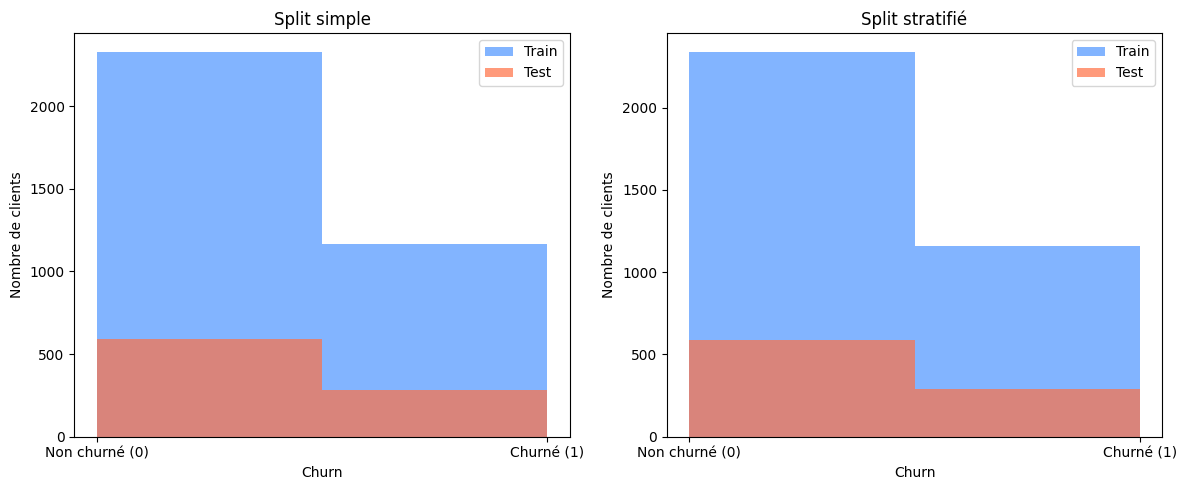

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, y_tr, y_te, title in zip(
    axes, [y_train, y_train_s], [y_test, y_test_s], ["Split simple", "Split stratifié"]
):
    ax.hist(y_tr, bins=2, alpha=0.7, label="Train", color="#4d94ff")
    ax.hist(y_te, bins=2, alpha=0.7, label="Test", color="#ff7043")
    ax.set_title(title)
    ax.set_xlabel("Churn")
    ax.set_ylabel("Nombre de clients")
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Non churné (0)", "Churné (1)"])
    ax.legend()

plt.tight_layout()
plt.show()

In [8]:
num_features = ["nb_commandes", "nb_produits", "montant_total"]
cat_features = ["pays"]

preprocessor = ColumnTransformer(
    transformers=[
        (
            "num",
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="median")),
                    ("scaler", StandardScaler()),
                ]
            ),
            num_features,
        ),
        (
            "cat",
            Pipeline(
                [
                    ("imputer", SimpleImputer(strategy="most_frequent")),
                    (
                        "encoder",
                        OneHotEncoder(handle_unknown="ignore", sparse_output=False),
                    ),
                ]
            ),
            cat_features,
        ),
    ]
)

full_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "classifier",
            RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        ),
    ]
)

## Cross-validation

In [9]:
METRICS = ["accuracy", "f1_macro", "precision_macro", "recall_macro"]

kf = KFold(n_splits=5, shuffle=True, random_state=42)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "LogisticRegression": LogisticRegression(max_iter=500, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(
        n_estimators=100, random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
}

pipelines = {
    name: Pipeline([("preprocessor", preprocessor), ("classifier", clf)])
    for name, clf in models.items()
}


In [10]:
kf_scores = {}
skf_scores = {}
for name, pipeline in pipelines.items():
    s_kf = cross_val_score(pipeline, X, y, cv=kf, scoring="accuracy", n_jobs=-1)
    s_skf = cross_val_score(pipeline, X, y, cv=skf, scoring="accuracy", n_jobs=-1)
    kf_scores[name] = s_kf
    skf_scores[name] = s_skf
    print(
        f"{name} : Kfold : moyenne : {s_kf.mean()} std : {s_kf.std()} | stratified : moyenne : {s_skf.mean()} std : {s_skf.std()}"
    )

LogisticRegression : Kfold : moyenne : 0.7172898332788493 std : 0.009959078854460625 | stratified : moyenne : 0.7156877410918601 std : 0.008082588321346649
DecisionTree : Kfold : moyenne : 0.6438713305001634 std : 0.016096420362764333 | stratified : moyenne : 0.638381954887218 std : 0.007465562848881208
RandomForest : Kfold : moyenne : 0.6804670807453416 std : 0.009433671750610835 | stratified : moyenne : 0.6731462569467146 std : 0.013195543175925075
GradientBoosting : Kfold : moyenne : 0.7065396534815299 std : 0.012937059447515845 | stratified : moyenne : 0.7037936580581889 std : 0.00982945382680401


In [11]:
cv_results = {}
for name, pipeline in pipelines.items():
    print(f"  cross_validate : {name}...")
    cv_results[name] = cross_validate(
        pipeline, X, y, cv=skf, scoring=METRICS, return_train_score=True, n_jobs=-1
    )


summary = []
for name, res in cv_results.items():
    acc = res["test_accuracy"].mean()
    f1 = res["test_f1_macro"].mean()
    prec = res["test_precision_macro"].mean()
    rec = res["test_recall_macro"].mean()
    summary.append(
        {"name": name, "accuracy": acc, "f1": f1, "precision": prec, "recall": rec}
    )
    print(f"{name} accuracy : {acc} f1 : {f1} precision : {prec} recall : {rec}")

best = max(summary, key=lambda x: x["f1"])
print(best)

  cross_validate : LogisticRegression...
  cross_validate : DecisionTree...
  cross_validate : RandomForest...
  cross_validate : GradientBoosting...
LogisticRegression accuracy : 0.7156877410918601 f1 : 0.6650250013114146 precision : 0.6759343111294847 recall : 0.6599667627549064
DecisionTree accuracy : 0.638381954887218 f1 : 0.5947282964690946 precision : 0.594250208372642 recall : 0.5953614209754975
RandomForest accuracy : 0.6731462569467146 f1 : 0.6143678461392887 precision : 0.6226911153958368 recall : 0.6109467921466032
GradientBoosting accuracy : 0.7037936580581889 f1 : 0.6484598249202063 precision : 0.6608883156235285 recall : 0.6434244859481042
{'name': 'LogisticRegression', 'accuracy': np.float64(0.7156877410918601), 'f1': np.float64(0.6650250013114146), 'precision': np.float64(0.6759343111294847), 'recall': np.float64(0.6599667627549064)}


(0.0, 1.05)

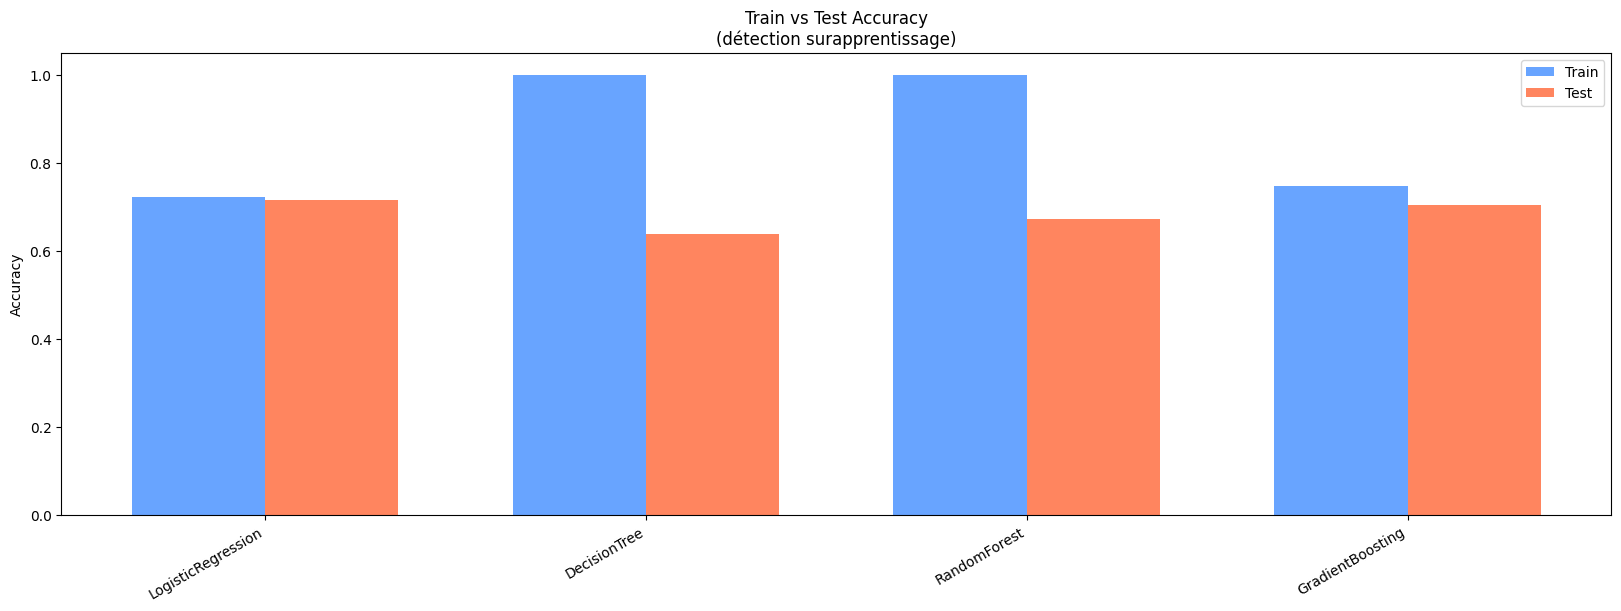

In [12]:
names = list(cv_results.keys())

fig, axes = plt.subplots(1, 1, figsize=(20, 6))

x2, w2 = np.arange(len(names)), 0.35
train_scores = [cv_results[n]["train_accuracy"].mean() for n in names]
test_scores = [cv_results[n]["test_accuracy"].mean() for n in names]
axes.bar(x2 - w2 / 2, train_scores, w2, label="Train", color="#4d94ff", alpha=0.85)
axes.bar(x2 + w2 / 2, test_scores, w2, label="Test", color="#ff7043", alpha=0.85)
axes.set_xticks(x2)
axes.set_xticklabels(names, rotation=30, ha="right")
axes.set_ylabel("Accuracy")
axes.set_title("Train vs Test Accuracy\n(détection surapprentissage)")
axes.legend()
axes.set_ylim(0, 1.05)

## Choix du modèle : LogisticRegression 

In [13]:
import time

from scipy.stats import loguniform, randint, uniform
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "classifier__C": loguniform(1e-4, 1e2),
    "classifier__penalty": ["l1", "l2", "elasticnet", None],
    "classifier__solver": ["saga"],  # saga supporte tous les types de penalty
    "classifier__max_iter": randint(100, 1000),
    "classifier__class_weight": [None, "balanced"],
    "classifier__l1_ratio": uniform(0, 1),  # uniquement utilisé si penalty='elasticnet'
}


lr_pipeline = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression(max_iter=500, random_state=42)),
    ]
)

random_search = RandomizedSearchCV(
    estimator=lr_pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="f1_macro",
    random_state=42,
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
    error_score="raise",
)


start_time = time.time()
random_search.fit(X_train_s, y_train_s)
random_search_time = time.time() - start_time

print("Meilleurs hyperparamètres trouvés :")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"Meilleur score F1 macro (CV) : {random_search.best_score_:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Meilleurs hyperparamètres trouvés :
  classifier__C: 11.673553877431997
  classifier__class_weight: None
  classifier__l1_ratio: 0.2713490317738959
  classifier__max_iter: 152
  classifier__penalty: None
  classifier__solver: saga
Meilleur score F1 macro (CV) : 0.6658


c:\Users\Administrateur\Documents\M2i_CDSD_TDTP\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
c:\Users\Administrateur\Documents\M2i_CDSD_TDTP\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1207: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
c:\Users\Administrateur\Documents\M2i_CDSD_TDTP\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Visualisation des scores :

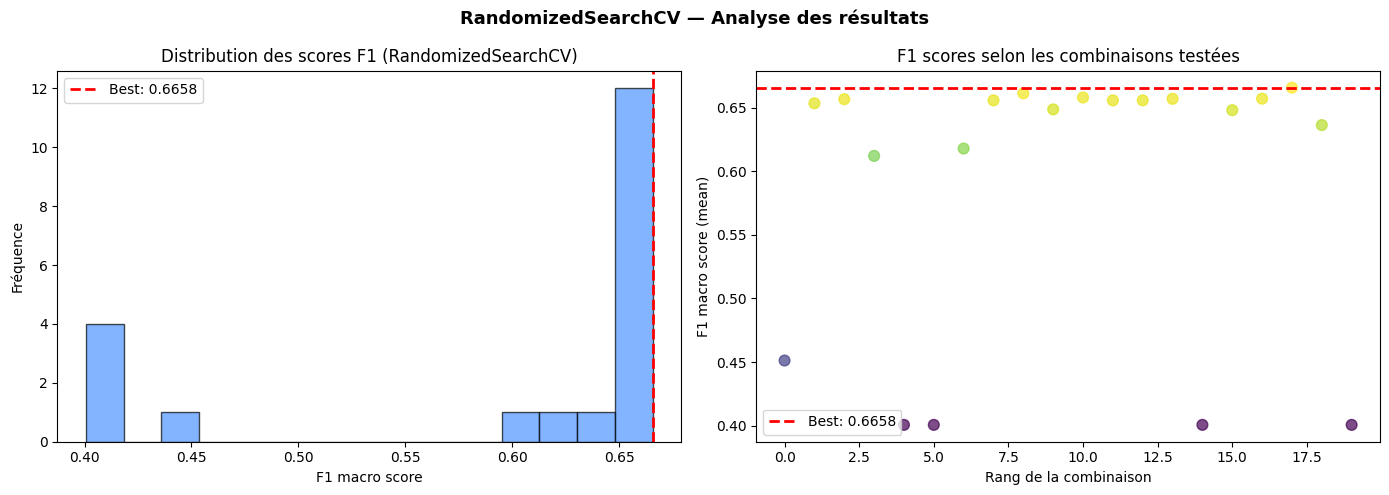

In [14]:
cv_results_random = pd.DataFrame(random_search.cv_results_)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(
    cv_results_random["mean_test_score"],
    bins=15,
    color="#4d94ff",
    alpha=0.7,
    edgecolor="black",
)
axes[0].axvline(
    random_search.best_score_,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Best: {random_search.best_score_:.4f}",
)
axes[0].set_xlabel("F1 macro score")
axes[0].set_ylabel("Fréquence")
axes[0].set_title("Distribution des scores F1 (RandomizedSearchCV)")
axes[0].legend()

axes[1].scatter(
    range(len(cv_results_random)),
    cv_results_random["mean_test_score"],
    c=cv_results_random["mean_test_score"],
    cmap="viridis",
    alpha=0.7,
    s=60,
)
axes[1].axhline(
    random_search.best_score_,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Best: {random_search.best_score_:.4f}",
)
axes[1].set_xlabel("Rang de la combinaison")
axes[1].set_ylabel("F1 macro score (mean)")
axes[1].set_title("F1 scores selon les combinaisons testées")
axes[1].legend()

plt.suptitle(
    "RandomizedSearchCV — Analyse des résultats", fontsize=13, fontweight="bold"
)
plt.tight_layout()
plt.show()

y_pred_random = random_search.best_estimator_.predict(X_test_s)

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__C": [10, 11, 11.1, 12],
    "classifier__penalty": ["l2", None],
    "classifier__solver": ["saga"],
    "classifier__class_weight": [None, "balanced"],
    "classifier__max_iter": [300, 500],
}

grid_search = GridSearchCV(
    estimator=lr_pipeline,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="f1_macro",
    n_jobs=-1,
    verbose=1,
    return_train_score=True,
)

start_time = time.time()
grid_search.fit(X_train_s, y_train_s)
grid_search_time = time.time() - start_time

for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nMeilleur score F1 macro (CV) : {grid_search.best_score_:.4f}")

# Évaluation sur le jeu de test
y_pred_grid = grid_search.best_estimator_.predict(X_test_s)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
  classifier__C: 10
  classifier__class_weight: None
  classifier__max_iter: 300
  classifier__penalty: l2
  classifier__solver: saga

Meilleur score F1 macro (CV) : 0.6638


c:\Users\Administrateur\Documents\M2i_CDSD_TDTP\.venv\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [16]:
from sklearn.metrics import f1_score

f1_random_test = f1_score(y_test_s, y_pred_random, average="macro")
f1_grid_test = f1_score(y_test_s, y_pred_grid, average="macro")

comparison_df = pd.DataFrame(
    {
        "Méthode": ["RandomizedSearchCV", "GridSearchCV"],
        "Meilleur F1 (CV)": [random_search.best_score_, grid_search.best_score_],
        "F1 test": [f1_random_test, f1_grid_test],
        "Combinaisons testées": [
            len(cv_results_random),
            len(pd.DataFrame(grid_search.cv_results_)),
        ],
        "Temps (s)": [random_search_time, grid_search_time],
    }
)

print(comparison_df.to_string(index=False))

           Méthode  Meilleur F1 (CV)  F1 test  Combinaisons testées  Temps (s)
RandomizedSearchCV          0.665791 0.674686                    20   2.066765
      GridSearchCV          0.663766 0.673951                    32   3.916874


# Partie 3

## Courbe d'apprentissage (Learning Curve)

### Mise en place

1. Reprenez votre meilleur modèle (pipeline complète avec les hyperparamètres optimaux).
2. Utilisez `learning_curve` de sklearn

In [17]:
train_sizes, train_scores, test_scores = learning_curve(
    random_search.best_estimator_,
    X_train,
    y_train,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring="f1_macro",
    n_jobs=-1,
    random_state=42,
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_mean = test_scores.mean(axis=1)
test_std = test_scores.std(axis=1)

### Visualisation

3. Tracez la courbe d'apprentissage avec :
   - L'axe X : la taille du jeu d'entraînement
   - L'axe Y : le score F1
   - Deux courbes : score moyen sur le train (en bleu) et score moyen sur le test (en orange)
   - Les zones d'ombre représentant l'écart-type (avec `fill_between`)

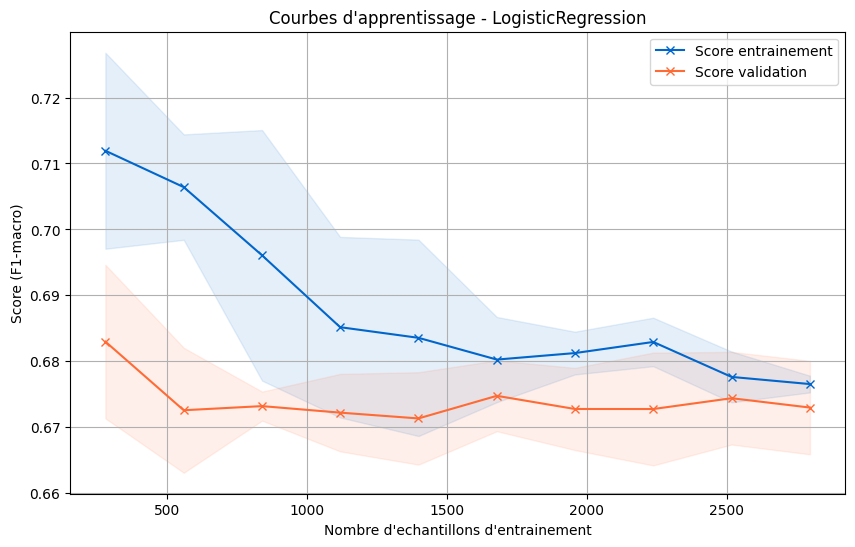

In [18]:
plt.figure(figsize=(10, 6))

plt.plot(train_sizes, train_mean, "x-", label="Score entrainement", color="#0066cc")
plt.plot(train_sizes, test_mean, "x-", label="Score validation", color="#ff6b35")
plt.fill_between(
    train_sizes,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.1,
    color="#0066cc",
)
plt.fill_between(
    train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color="#ff6b35"
)
plt.xlabel("Nombre d'echantillons d'entrainement")
plt.ylabel("Score (F1-macro)")
plt.title("Courbes d'apprentissage - LogisticRegression")
plt.legend()
plt.grid(True)

plt.show()

## Courbe ROC-AUC et seuil de Youden

### Mise en place

1. Entraînez votre meilleur modèle sur l'ensemble du jeu d'entraînement.
2. Récupérez les probabilités de prédiction sur le jeu de test avec `predict_proba`.
3. Calculez la courbe ROC avec `roc_curve` de sklearn en utilisant les probabilités de la classe positive.
4. Calculez l'AUC-ROC avec `roc_auc_score`.

In [19]:
y_proba = random_search.best_estimator_.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)

print(f"AUC : {auc}")

AUC : 0.7680062786824354


### Calcul du seuil de Youden

5. Calculez l'indice de Youden pour chaque seuil : `J = TPR - FPR` (ou `J = Sensitivity + Specificity - 1`)
6. Identifiez le seuil qui maximise l'indice de Youden.
7. Affichez le seuil optimal de Youden et les valeurs de TPR et FPR associées.

In [20]:
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]
print("Seuil optimal : ", optimal_threshold)

Seuil optimal :  0.41902038175040984


### Visualisation de la courbe ROC

8. Tracez la courbe ROC avec :
   - L'axe X : False Positive Rate (FPR)
   - L'axe Y : True Positive Rate (TPR)
   - Une ligne diagonale en pointillés représentant un classifieur aléatoire
   - L'AUC dans le label de la courbe
   - Un marqueur rouge au point correspondant au seuil de Youden

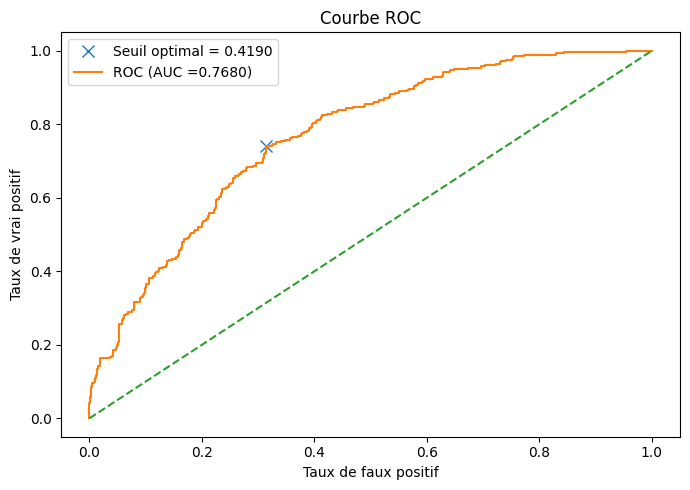

In [21]:
fig, axes = plt.subplots(1, 1, figsize=(7, 5))

axes.plot(
    fpr[optimal_idx],
    tpr[optimal_idx],
    "x",
    markersize=8,
    label=f"Seuil optimal = {optimal_threshold:.4f}",
)

axes.plot(fpr, tpr, label=f"ROC (AUC ={auc:.4f})")
axes.plot([0, 1], [0, 1], "--")

axes.set_title("Courbe ROC")
axes.set_xlabel("Taux de faux positif")
axes.set_ylabel("Taux de vrai positif")
axes.legend()

plt.tight_layout()
plt.show()